# **2021-2022 MD/PhD Cycle Analyzer**

In [1]:
import re
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import math
import string
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

In [2]:
def text_parser(filepath):
    """
    Function for parsing through a .txt file of schools with users + dates.
    Provide a filepath for each .txt file
    """
    school_list = []
    file = open(filepath)
    for line in file:
        school_list.append(line)
    return(school_list)

In [3]:
def cycle_generator(text_list, cycle_start_year):
    """
    Function to select schools, users, complete & interview dates.
    Make sure to clean and edit the txt files before running this - otherwise it throws errors with bad dates.
    Provide a text list from text_parser and the start year of the cycle.
    """
    schools = []
    first_users = []
    other_users = []
    completes_interviews = []
    
    for school in text_list:
        s = re.findall(pattern="^(.*?):", string=school)
        for sc in s:
            schools.append(sc)
        
        user1 = re.findall(pattern=":(.*?)\(", string=school)[0]
        user1 = user1.replace(" ", "")
        first_users.append(user1)
        
        users = re.findall(pattern="\),(.*?)\(", string=school)
        users = [u.replace(" ", "") for u in users]
        other_users.append(users)
        
        ci = re.findall(pattern="\((.*?)\)", string=school)
        com_int = []
        for x in ci:
            x = x.replace(" ", "")
            x = x.upper()
            com_int.append(x)
        completes_interviews.append(com_int)
    
    all_users = []
    for f, o in zip(first_users, other_users):
        f = [f]
        total = f + o
        all_users.append(total)
    
    ii_df = pd.DataFrame({'schools': schools, 'users': all_users, 'complete_interview': completes_interviews})
    #return(ii_df)

    ii_df_users = ii_df.loc[:, ['schools', 'users']].explode('users').reset_index(drop=True)
    ii_df_ci = ii_df.loc[:, ['schools', 'complete_interview']].explode('complete_interview').reset_index(drop=True)
    #return(len(ii_df_users))
    #return(len(ii_df_ci))
    ii_df_users['complete_interview'] = ii_df_ci['complete_interview']
    ii_df_all = ii_df_users
    #return(ii_df_all)
    
    cs = []
    iis = []
    for ci in ii_df_all['complete_interview']:
        
        c = re.findall(pattern="C:(.*?),", string=ci)[0]
        c_dates = c.split('/')
        if int(c_dates[0]) > 5:
            try:
                c = c + "/" + str(cycle_start_year)
                c = datetime.strptime(c, '%m/%d/%Y')
            except:
                c = np.nan        
        if int(c_dates[0]) < 5:
            try:
                c = c + "/" + str(cycle_start_year + 1)
                c = datetime.strptime(c, '%m/%d/%Y')
            except:
                c = np.nan
        cs.append(c)
        
        ii = re.findall(pattern="II:(.*)", string=ci)[0]
        ii_dates = ii.split('/')
        if int(ii_dates[0]) > 5:
            try:
                ii = ii + "/" + str(cycle_start_year)
                ii = datetime.strptime(ii, '%m/%d/%Y')
            except:
                ii = np.nan        
        if int(ii_dates[0]) < 5:
            try:
                ii = ii + "/" + str(cycle_start_year + 1)
                ii = datetime.strptime(ii, '%m/%d/%Y')
            except:
                ii = np.nan
        iis.append(ii)
    
    ii_df_all['complete_date'] = cs
    ii_df_all['II_date'] = iis
    ii_df_all['wait_time'] = (ii_df_all['II_date'] - ii_df_all['complete_date']).dt.days
    ii_df_all['cycle'] = str(cycle_start_year) + "-" + str(cycle_start_year + 1)
    return(ii_df_all)

In [4]:
directory = "C:/Users/TooFastDan/Documents/MD_PhD Application/Python Analysis/SDN interviews"
cycle_2021 = text_parser(filepath=directory + "/2021-2022 interview invites 2021-10-15.txt")
cycle_2020 = text_parser(filepath=directory + "/2020-2021 interview invites.txt")
cycle_2019 = text_parser(filepath=directory + "/2019-2020 interview invites.txt")
cycle_2018 = text_parser(filepath=directory + "/2018-2019 interview invites.txt")

In [5]:
ii_2021 = cycle_generator(text_list=cycle_2021, cycle_start_year=2021)
ii_2020 = cycle_generator(text_list=cycle_2020, cycle_start_year=2020)
ii_2019 = cycle_generator(text_list=cycle_2019, cycle_start_year=2019)
ii_2018 = cycle_generator(text_list=cycle_2018, cycle_start_year=2018)
print("2021-2022 cycle users:", len(ii_2021),
      "\n2020-2021 cycle users:", len(ii_2020), 
      "\n2019-2020 cycle users:", len(ii_2019),
      "\n2018-2019 cycle users:", len(ii_2018))

2021-2022 cycle users: 236 
2020-2021 cycle users: 362 
2019-2020 cycle users: 359 
2018-2019 cycle users: 397


In [13]:
# Redoing the cycle column
ii_2021['cycle'] = '2021-2022 *Incomplete'
ii_2020['cycle'] = '2020-2021'
ii_2019['cycle'] = '2019-2020'
ii_2018['cycle'] = '2018-2019'

# Dropping na values for interviews
#ii_2021 = ii_2021[ii_2021['II_date'].notna()]
#ii_2020 = ii_2020[ii_2020['II_date'].notna()]
#ii_2019 = ii_2019[ii_2019['II_date'].notna()]
#ii_2018 = ii_2018[ii_2018['II_date'].notna()]

# Sorting by interview invite date
ii_2021 = ii_2021.sort_values(by="II_date")
ii_2020 = ii_2020.sort_values(by="II_date")
ii_2019 = ii_2019.sort_values(by="II_date")
ii_2018 = ii_2018.sort_values(by="II_date")

# Numbering every II
ii_2021['rank'] = [i+1 for i in range(len(ii_2021))]
ii_2020['rank'] = [i+1 for i in range(len(ii_2020))]
ii_2019['rank'] = [i+1 for i in range(len(ii_2019))]
ii_2018['rank'] = [i+1 for i in range(len(ii_2018))]

# Creating a percent for suvival analysis
ii_2021['percent'] = (ii_2021['rank'] / 370) * 100  #assuming there are 370 final entries
ii_2020['percent'] = (ii_2020['rank'] / len(ii_2020)) * 100
ii_2019['percent'] = (ii_2019['rank'] / len(ii_2019)) * 100
ii_2018['percent'] = (ii_2018['rank'] / len(ii_2018)) * 100

# Concatenating all application cycles into one df
ii_all = pd.concat([ii_2021, ii_2020, ii_2019, ii_2018], axis=0, ignore_index=True)

In [20]:
# Deidentifying everyone and sorting

#ii_all_de = ii_all.drop(["users", "rank", "percent"], axis=1)
#ii_all_de["cycle"] = pd.Categorical(ii_all_de["cycle"], ["2021-2022 *Incomplete", "2020-2021", "2019-2020", "2018-2019"])
#ii_all_de = ii_all_de.sort_values(by=["cycle", "schools"])
#ii_all_de.to_excel(directory+"/all_iis_deidentified.xlsx", index=False)

In [12]:
display(ii_all)
#ii_all.to_excel(directory+"/all_iis_processed.xlsx", index=False)

print("2021-2022 cycle users:", len(ii_2021),
      "\n2020-2021 cycle users:", len(ii_2020), 
      "\n2019-2020 cycle users:", len(ii_2019),
      "\n2018-2019 cycle users:", len(ii_2018))

,schools,complete_interview,complete_date,II_date,wait_time,cycle,rank,percent
0,UT San Antonio,"C:7/10,II:7/30",2021-07-10,2021-07-30,20.0,2021-2022 *Incomplete,1,0.270270
1,Texas A&M,"C:7/19,II:7/30",2021-07-19,2021-07-30,11.0,2021-2022 *Incomplete,2,0.540541
2,UT San Antonio,"C:7/10,II:7/30",2021-07-10,2021-07-30,20.0,2021-2022 *Incomplete,3,0.810811
3,UT San Antonio,"C:7/10,II:7/30",2021-07-10,2021-07-30,20.0,2021-2022 *Incomplete,4,1.081081
4,UT San Antonio,"C:7/10,II:7/30",2021-07-10,2021-07-30,20.0,2021-2022 *Incomplete,5,1.351351
...,...,...,...,...,...,...,...,...
1349,Case Western,"C:8/26,II:2/10",2018-08-26,2019-02-10,168.0,2018-2019,393,98.992443
1350,University of Virginia,"C:12/15,II:2/11",2018-12-15,2019-02-11,58.0,2018-2019,394,99.244332
1351,UT Houston,"C:9/X,II:12/X",NaT,NaT,NaN,2018-2019,395,99.496222
1352,UT San Antonio,"C:9/X,II:11/X",NaT,NaT,NaN,2018-2019,396,99.748111


2021-2022 cycle users: 236 
2020-2021 cycle users: 362 
2019-2020 cycle users: 359 
2018-2019 cycle users: 397


### Kaplan-Meier Suvival Curves

<ipython-input-9-f495caeb6065>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


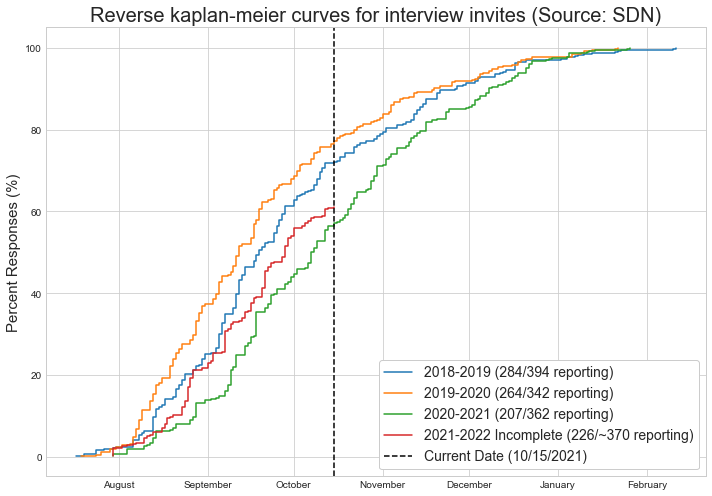

In [9]:
%matplotlib inline
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(10, 7))

ax.step(x=ii_2018['II_date'], y=ii_2018['percent'], label="2018-2019 (284/394 reporting)", where="post")
ax.step(x=ii_2019['II_date'], y=ii_2019['percent'], label="2019-2020 (264/342 reporting)", where="post")
ax.step(x=ii_2020['II_date'], y=ii_2020['percent'], label="2020-2021 (207/362 reporting)", where="post")
ax.step(x=ii_2021['II_date'], y=ii_2021['percent'], label="2021-2022 Incomplete (226/~370 reporting)", where="post")

plt.axvline(x=datetime.strptime("10/15/2021", '%m/%d/%Y'), color="#000000", ls="--", lw=1.5, 
            label='Current Date (10/15/2021)')

#plt.xlabel("Date")
tick_labels = ['August', 'September', 'October', 'November', 'December', 'January', 'February']
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Percent Responses (%)", fontsize=15)
ax.set_title("Reverse kaplan-meier curves for interview invites (Source: SDN)", fontsize=20)
ax.legend(fontsize=14, loc='lower right', facecolor='white', framealpha=1, frameon=True)
plt.tight_layout()

#plt.savefig(directory+"/kaplan-meier iis.png", dpi=300)

### Population Density Curves

<ipython-input-24-b9cfd61d2295>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(tick_labels)


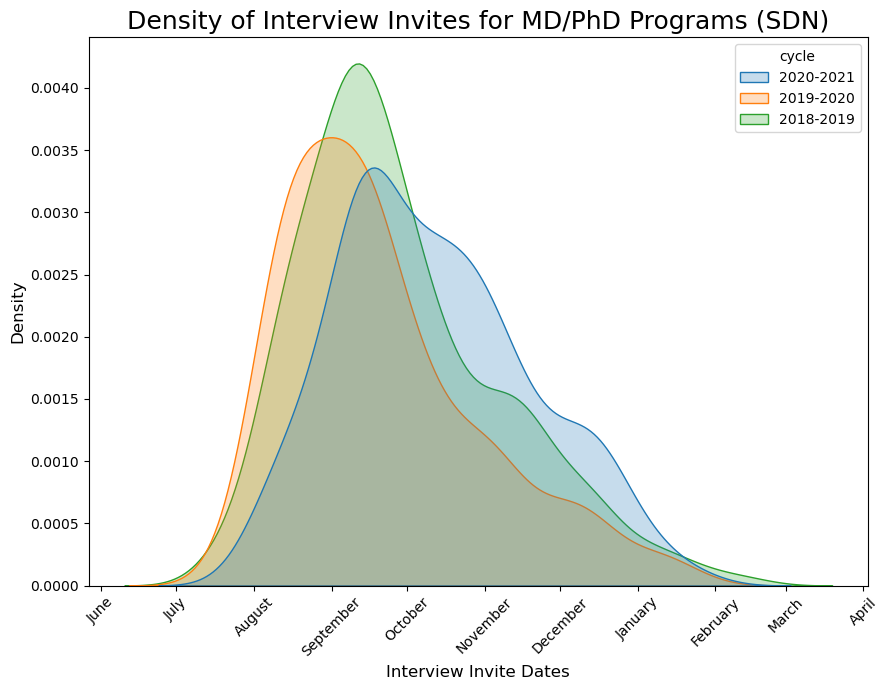

In [24]:
%matplotlib inline
#sns.set_style("ticks")
plt.style.use("default")
plt.figure(figsize=(9, 7))

plot = sns.kdeplot(data=ii_all, x="II_date", hue='cycle', fill=True)

plt.xticks(rotation=45)
plot.set_xlabel("Interview Invite Dates", fontsize=12)
tick_labels = ["June", "July", "August", "September", "October", "November", "December", "January", "February", "March", "April"]
plot.set_xticklabels(tick_labels)
plot.set_ylabel("Density", fontsize=12)
plot.set_title("Density of Interview Invites for MD/PhD Programs (SDN)", fontsize=18)
plt.tight_layout()

#plt.savefig('ii_kde.png', dpi=300)

### **Plotting Complete Date vs Wait Time**

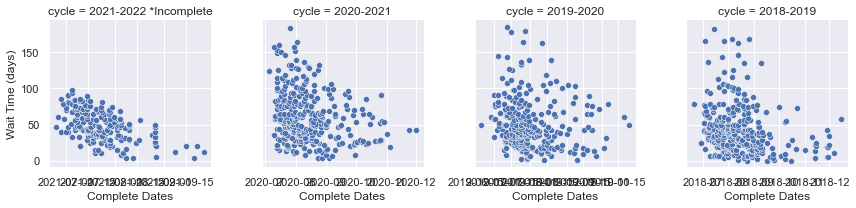

In [52]:
#ii_2021_2 = ii_2021[ii_2021["complete_date"].notna()]
#ii_2021_2
%matplotlib inline

ii_all_2 = ii_all[ii_all["complete_date"].notna()]

#sns.set(rc={'figure.figsize':(12, 8)})
grid = sns.FacetGrid(ii_all_2, col="cycle", sharex=False)
grid.map(sns.scatterplot, "complete_date", "wait_time")
grid.set_axis_labels(x_var="Complete Dates", y_var="Wait Time (days)")

plt.tight_layout()

### Plotting a bargraph of waittimes between secondary completion and interview invite

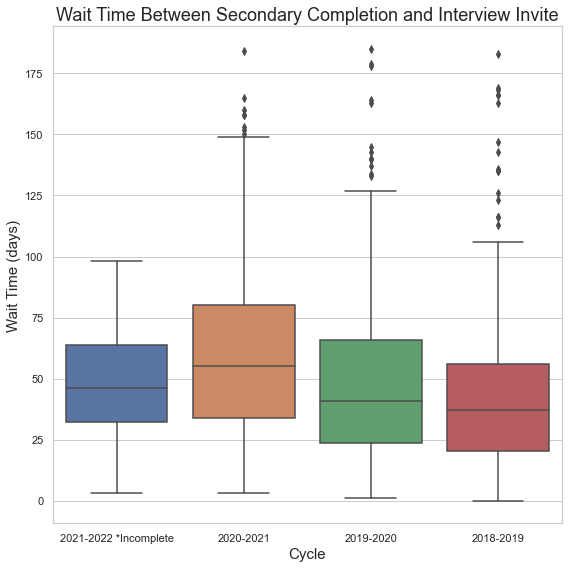

In [54]:
plt.figure(figsize=(8,8))
sns.set_style("whitegrid")

sns.boxplot(data=ii_all_2, x="cycle", y="wait_time")
plt.xlabel("Cycle", fontsize=15)
plt.ylabel("Wait Time (days)", fontsize=15)
plt.title("Wait Time Between Secondary Completion and Interview Invite", fontsize=18)

plt.tight_layout()

plt.savefig(directory+"/wait time boxplot.jpg", dpi=300)

### Making a plot of the most common days of the week to be sent interview invites

In [10]:
# 0 = monday, 1 = tueday, 2 = wednesday, 3 = thursday, 4 = friday, 5 = saturday, 6 = sunday
ii_2021["weekdays"] = [ii.weekday() for ii in ii_2021["II_date"]]
ii_2021["weekdays"].replace({0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}, inplace=True)
days_df = pd.DataFrame(ii_2021["weekdays"].value_counts().reset_index())
days_df.columns = ["Week Day", "Count"]

# Sorting according to weekday
days_df["Week Day"] = pd.Categorical(days_df["Week Day"], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
days_df.sort_values("Week Day", inplace=True)
days_df

,Week Day,Count
3,Monday,33
0,Tuesday,72
2,Wednesday,41
4,Thursday,31
1,Friday,46
5,Saturday,2
6,Sunday,1


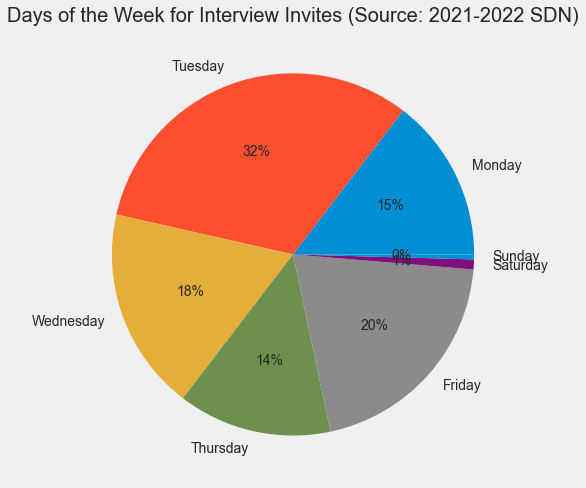

In [12]:
%matplotlib inline
plt.style.use("fivethirtyeight")
#sns.set_style("ticks")
plt.figure(figsize=(9, 7))

#colors = ['grey' for x in days_df["Week Day"]]
#bar = sns.barplot(data=days_df, x="Week Day", y="Count", palette=colors)
#colors = sns.color_palette("pastel")

pie = plt.pie(x=days_df["Count"], labels=days_df["Week Day"], autopct='%.0f%%')
plt.title("Days of the Week for Interview Invites (Source: 2021-2022 SDN)", fontsize=20)
plt.tight_layout()

#plt.savefig(directory+"/weekdays.png", dpi=300)

## **Generating Summary Statistics**

In [18]:
def summary_stats(df):
    """
    Creating some summary statistics and making dataframes to export.
    Returns 3 dataframes.
    """
    total_iis = len(df)
    total_programs = len(pd.unique(df['schools']))
    sdn_users = len(pd.unique(df['users']))
    summary_stats = [total_iis, total_programs, sdn_users]
    rownames = ["Total number of interview invites reported on SDN", 
                "Number of programs reporting interviews on SDN",
                "Number of unique users on SDN"]
    summary_df = pd.DataFrame(summary_stats, index=rownames, columns=["Number Reporting"])
    school_iis = pd.DataFrame({"II's per school on SDN": df['schools'].value_counts()})
    user_iis = pd.DataFrame({"II's per SDN user": df['users'].value_counts()})
    return(summary_df, school_iis, user_iis)

In [19]:
summary_df, school_iis, user_iis = summary_stats(df=ii_2021)
display(summary_df)
display(school_iis)
display(user_iis)

,Number Reporting
Total number of interview invites reported on SDN,236
Number of programs reporting interviews on SDN,69
Number of unique users on SDN,47


,II's per school on SDN
Emory,10
Icahn School of Medicine at Mount Sinai,8
UT San Antonio,8
Weill Cornell/Rockefeller/Sloan Kettering - Tri-I,7
University of Iowa,7
...,...
University of Connecticut,1
Virginia Commonwealth University,1
University of North Carolina,1
University of Louisville,1


,II's per SDN user
DrDriven07,17
mdphd63627,15
MacroPhagoCytosis,14
toolcake,11
TheCicadaCircle,10
MDPhDcapable,9
NeuroImmunoMSTP,9
yibs,9
humoralhuman,9
larynxlady,9


In [21]:
### Writing to a multi-sheet excel doc ###
writer = pd.ExcelWriter(directory+'/2021-2022 summary stats.xlsx', engine='xlsxwriter')

summary_df.to_excel(writer, sheet_name="Summary_Stats")
school_iis.to_excel(writer, sheet_name="IIs_per_program")
user_iis.to_excel(writer, sheet_name="IIs_per_SDNuser")
ii_2021.to_excel(writer, sheet_name="cycle_processed", index=False)

writer.save()
writer.close()

C:\Users\TooFastDan\anaconda3\lib\site-packages\xlsxwriter\workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [20]:
# Checking the number of schools, number of IIs per school, number of users, and number of IIs per user 
print("Total number of interview invites reported on SDN:", len(ii_2021))
print("\n")
print("Number of programs reporting interviews on SDN:", len(pd.unique(ii_2021['schools'])))
print("\n")
print("Number of individual users on SDN:", len(pd.unique(ii_2021['users'])))
print("\n")
print("Number of interview invites per program:\n", 
      pd.DataFrame({"ii_number": ii_2021['schools'].value_counts()}))
print("\n")
print("Number of interviews per user on SDN:\n",
      pd.DataFrame({"ii_per_user": ii_2021['users'].value_counts()}))

Total number of interview invites reported on SDN: 236


Number of programs reporting interviews on SDN: 69


Number of individual users on SDN: 47


Number of interview invites per program:
                                                    ii_number
Emory                                                     10
Icahn School of Medicine at Mount Sinai                    8
UT San Antonio                                             8
Weill Cornell/Rockefeller/Sloan Kettering - Tri-I          7
University of Iowa                                         7
...                                                      ...
University of Connecticut                                  1
Virginia Commonwealth University                           1
University of North Carolina                               1
University of Louisville                                   1
Rutgers New Jersey Medical School                          1

[69 rows x 1 columns]


Number of interviews per user on SDN:
             

In [120]:
?plt.axvline

In [65]:
?plt.step

In [125]:
?plt.savefig

# Spare work for random analysis

In [149]:
schools = []
first_users = []
other_users = []
completes_interviews = []

for school in cycle_2022:
    s = re.findall(pattern="^(.*?):", string=school)
    for sc in s:
        schools.append(sc)
    
    user1 = re.findall(pattern=":(.*?)\(", string=school)[0]
    user1 = user1.replace(" ", "")
    first_users.append(user1)
    
    users = re.findall(pattern="\),(.*?)\(", string=school)
    users = [u.replace(" ", "") for u in users]
    other_users.append(users)
    
    ci = re.findall(pattern="\((.*?)\)", string=school)
    com_int = []
    for x in ci:
        x = x.replace(" ", "")
        x = x.upper()
        com_int.append(x)
    completes_interviews.append(com_int)

all_users = []
for f, o in zip(first_users, other_users):
    f = [f]
    total = f + o
    all_users.append(total)

ii_df = pd.DataFrame({'schools': schools, 'users': all_users, 'complete_interview': completes_interviews})
#display(ii_df)

,schools,users,complete_interview
0,Case Western Reserve University,"[mdphd63627, toofastdan, ThJSTRY, DrDriven07, ...","[C:7/16,II:8/26, C:7/16,II:8/26, C:7/20,II:8/2..."
1,Columbia,"[MacroPhagoCytosis, larynxlady, DrDriven07]","[C:7/14,II:8/25, C:7/15,II:8/25, C:7/8,II:8/25]"
2,Donald and Barbara Zucker School of Medicine a...,"[florizel, installation2020, swagyolo, lucyaxo...","[C:7/9,II:8/11, C:8/8,II:8/11, C:7/18,II:8/18,..."
3,Icahn School of Medicine at Mount Sinai,"[MDPhDcapable, installation2020, lucyaxolotl]","[C:7/1X,II:8/0X, C:8/8,II:8/24, C:7/5,II:8/6]"
4,Indiana University,"[misterjohndoe, DrDriven07]","[C:7/1,II:8/10, C:7/2,II:8/10]"
5,Northwestern,"[MacroPhagoCytosis, toofastdan, humoralhuman, ...","[C:7/28,II:8/25, C:7/19,II:8/25, C:7/24,II:8/2..."
6,NYU,"[humoralhuman, lucyaxolotl]","[C:7/7,II:8/23, C:7/18,II:8/23]"
7,Ohio State University,"[mickmars51, DrDriven07]","[C:7/18,II:8/13, C:7/18,II:8/13]"
8,Texas A&M,"[misterjohndoe, mickmars51, VaultArmitage, baz...","[C:7/19,II:7/30, C:8/6,II:8/16, C:8/12,II:8/16..."
9,UT San Antonio,"[MacroPhagoCytosis, larynxlady, DrDriven07, ba...","[C:7/10,II:7/30, C:7/10,II:7/30, C:7/10,II:7/3..."


In [150]:
ii_df_users = ii_df.loc[:, ['schools', 'users']].explode('users').reset_index(drop=True)
ii_df_ci = ii_df.loc[:, ['schools', 'complete_interview']].explode('complete_interview').reset_index(drop=True)
print(len(ii_df_users))
print(len(ii_df_ci))
ii_df_users['complete_interview'] = ii_df_ci['complete_interview']
ii_df_all = ii_df_users
display(ii_df_all)

70
70


,schools,users,complete_interview
0,Case Western Reserve University,mdphd63627,"C:7/16,II:8/26"
1,Case Western Reserve University,toofastdan,"C:7/16,II:8/26"
2,Case Western Reserve University,ThJSTRY,"C:7/20,II:8/26"
3,Case Western Reserve University,DrDriven07,"C:7/15,II:8/26"
4,Case Western Reserve University,pharmabro11,"C:7/23,II:8/26"
...,...,...,...
65,Weill Cornell/Rockefeller/Sloan Kettering,DrDriven07,"C:7/21,II:8/4"
66,Weill Cornell/Rockefeller/Sloan Kettering,mickmars51,"C:7/15,II:8/18"
67,Weill Cornell/Rockefeller/Sloan Kettering,NeuroImmunoMSTP,"C:7/27,II:8/18"
68,Weill Cornell/Rockefeller/Sloan Kettering,yibs,"C:7/30,II:8/19"


In [151]:
cs = []
iis = []
for ci in ii_df_all['complete_interview']:
    
    c = re.findall(pattern="C:(.*?),", string=ci)[0]
    c_dates = c.split('/')
    if int(c_dates[0]) > 5:
        try:
            c = c + "/2021"
            c = datetime.strptime(c, '%m/%d/%Y')
        except:
            c = np.nan        
    if int(c_dates[0]) < 5:
        try:
            c = c + "/2022"
            c = datetime.strptime(c, '%m/%d/%Y')
        except:
            c = np.nan
    cs.append(c)
    
    ii = re.findall(pattern="II:(.*)", string=ci)[0]
    ii_dates = ii.split('/')
    if int(ii_dates[0]) > 5:
        try:
            ii = ii + "/2021"
            ii = datetime.strptime(ii, '%m/%d/%Y')
        except:
            ii = np.nan        
    if int(ii_dates[0]) < 5:
        try:
            ii = ii + "/2022"
            ii = datetime.strptime(ii, '%m/%d/%Y')
        except:
            ii = np.nan
    iis.append(ii)

ii_df_all['complete_date'] = cs
ii_df_all['II_date'] = iis
ii_df_all

,schools,users,complete_interview,complete_date,II_date
0,Case Western Reserve University,mdphd63627,"C:7/16,II:8/26",2021-07-16,2021-08-26
1,Case Western Reserve University,toofastdan,"C:7/16,II:8/26",2021-07-16,2021-08-26
2,Case Western Reserve University,ThJSTRY,"C:7/20,II:8/26",2021-07-20,2021-08-26
3,Case Western Reserve University,DrDriven07,"C:7/15,II:8/26",2021-07-15,2021-08-26
4,Case Western Reserve University,pharmabro11,"C:7/23,II:8/26",2021-07-23,2021-08-26
...,...,...,...,...,...
65,Weill Cornell/Rockefeller/Sloan Kettering,DrDriven07,"C:7/21,II:8/4",2021-07-21,2021-08-04
66,Weill Cornell/Rockefeller/Sloan Kettering,mickmars51,"C:7/15,II:8/18",2021-07-15,2021-08-18
67,Weill Cornell/Rockefeller/Sloan Kettering,NeuroImmunoMSTP,"C:7/27,II:8/18",2021-07-27,2021-08-18
68,Weill Cornell/Rockefeller/Sloan Kettering,yibs,"C:7/30,II:8/19",2021-07-30,2021-08-19


In [152]:
# Checking the number of schools, number of IIs per school, number of users, and number of IIs per user 
print("Total number of interview invites reported on SDN:", len(ii_df_all))
print("\n")
print("Number of programs reporting interviews on SDN:", len(pd.unique(ii_df_all['schools'])))
print("\n")
print("Number of individual users on SDN:", len(pd.unique(ii_df_all['users'])))
print("\n")
print("Number of interview invites per program:\n", 
      pd.DataFrame({"ii_number": ii_df_all['schools'].value_counts()}))
print("\n")
print("Number of interviews per user on SDN:\n",
      pd.DataFrame({"ii_per_user": ii_df_all['users'].value_counts()}))

Total number of interview invites reported on SDN: 70


Number of programs reporting interviews on SDN: 28


Number of individual users on SDN: 26


Number of interview invites per program:
                                                     ii_number
UT San Antonio                                              6
Case Western Reserve University                             5
Texas A&M                                                   5
Northwestern                                                4
Weill Cornell/Rockefeller/Sloan Kettering                   4
Donald and Barbara Zucker School of Medicine at...          4
Washington University in St. Louis                          3
University of Pittsburgh                                    3
Columbia                                                    3
Icahn School of Medicine at Mount Sinai                     3
UT Southwestern                                             3
University of Iowa                                          2
Sto

In [153]:
ii_df_rank = ii_df_all.dropna().sort_values(by="II_date").reset_index(drop=True)
ii_df_rank['rank'] = [i+1 for i in range(len(ii_df_rank))]
ii_df_rank['percent'] = (ii_df_rank['rank'] / len(ii_df_rank)) * 100
ii_df_rank

,schools,users,complete_interview,complete_date,II_date,rank,percent
0,UT San Antonio,NeuroImmunoMSTP,"C:7/10,II:7/30",2021-07-10,2021-07-30,1,1.5625
1,UT San Antonio,lucyaxolotl,"C:7/10,II:7/30",2021-07-10,2021-07-30,2,3.1250
2,UT San Antonio,baz2020,"C:7/10,II:7/30",2021-07-10,2021-07-30,3,4.6875
3,UT San Antonio,DrDriven07,"C:7/10,II:7/30",2021-07-10,2021-07-30,4,6.2500
4,Texas A&M,misterjohndoe,"C:7/19,II:7/30",2021-07-19,2021-07-30,5,7.8125
...,...,...,...,...,...,...,...
59,UT Southwestern,TokyoDrifter,"C:7/29,II:8/27",2021-07-29,2021-08-27,60,93.7500
60,Vanderbilt,toofastdan,"C:7/14,II:8/27",2021-07-14,2021-08-27,61,95.3125
61,University of Pittsburgh,pharmabro11,"C:7/15,II:8/27",2021-07-15,2021-08-27,62,96.8750
62,West Virginia University,mdphd63627,"C:7/28,II:8/27",2021-07-28,2021-08-27,63,98.4375


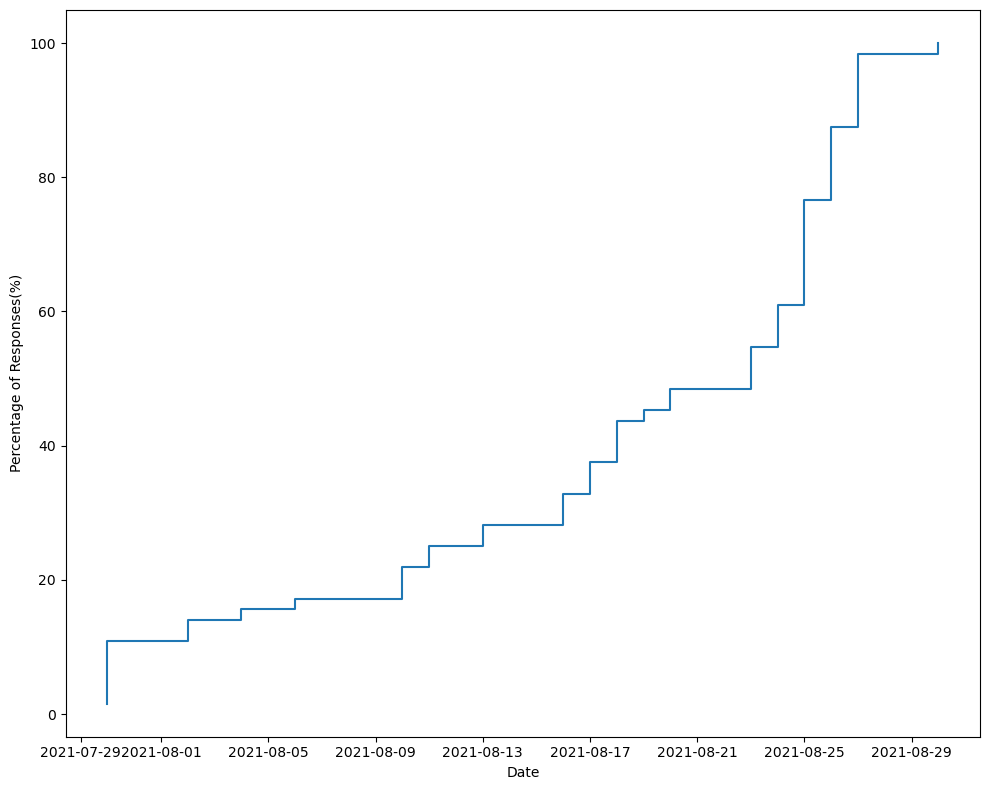

In [164]:
%matplotlib inline
plt.style.use("default")
plt.figure(figsize=(10, 8))

plt.step(x=ii_df_rank['II_date'], y=ii_df_rank['percent'], where="post")
plt.xlabel("Date")
plt.ylabel("Percentage of Responses(%)")
plt.tight_layout()

In [154]:
?plt.step

In [3]:
cyy = 2021
test_string = str(cyy) + "-" + str(cyy + 1)
print(test_string)

2021-2022
